In [1]:
# Import
import pandas as pd
from finta import TA as ta
from pandas.tseries.offsets import DateOffset
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from pathlib import Path
from sklearn.neighbors import KNeighborsClassifier

# Setting these options will allow for reviewing more of the DataFrames
pd.set_option('display.max_rows', 2000)
pd.set_option('display.max_columns', 2000)
pd.set_option('display.width', 1000)

In [2]:
ticker1 = "BTC"
ticker2 = "USDT"
pair= "{}{}".format(ticker1,ticker2)
start="2019.1.1"
end = "2022.4.1"
filepath = "Resources/{}_{}_to_{}.csv".format(pair,start,end)

df = pd.read_csv(Path(filepath), index_col= "Date", parse_dates= True, infer_datetime_format = True)
display(df.head())
display(df.tail())

,Open,High,Low,Close,Volume
Date,,,,,
2019-01-01 00:00:00,3701.23,3713.00,3689.88,3700.31,686.367420
2019-01-01 01:00:00,3700.20,3702.73,3684.22,3689.69,613.539115
2019-01-01 02:00:00,3689.67,3695.95,3675.04,3690.00,895.302181
2019-01-01 03:00:00,3690.00,3699.77,3685.78,3693.13,796.714818
2019-01-01 04:00:00,3692.32,3720.00,3685.94,3692.71,1317.452909


,Open,High,Low,Close,Volume
Date,,,,,
2022-03-31 20:00:00,45581.98,45790.00,45519.03,45745.46,1550.11357
2022-03-31 21:00:00,45745.45,45849.99,45647.01,45757.19,887.89890
2022-03-31 22:00:00,45757.19,45820.34,45660.68,45787.85,1058.12591
2022-03-31 23:00:00,45787.85,45787.86,45200.00,45510.34,2889.28168
2022-04-01 00:00:00,45510.35,45644.86,45351.73,45541.50,1838.20071


In [3]:
def appendData(maindf, dataarray, namesarray=None):
    if namesarray==None:
        return maindf.join(pd.DataFrame(dataarray), how='outer')
    return maindf.join(pd.DataFrame(dataarray,columns=namesarray), how='outer')

In [4]:
### Oscillators ###
## RSI
df = appendData(df,ta.RSI(df))
## Sto-%K
df = appendData(df,ta.STOCH(df))
## CCI
df = appendData(df,ta.CCI(df))
## ADX
df = appendData(df,ta.ADX(df))
## DMI (Added to aid in interpreting ADX)
df = appendData(df,ta.DMI(df, 14))
## Awesome
df = appendData(df,ta.AO(df))
## Momentum
df = appendData(df,ta.MOM(df,10))
## MACD (We rename the undescriptive "SIGNAL" here)
df = appendData(df,ta.MACD(df)).rename(columns={"SIGNAL": "MACD SIGNAL"})
## Sto-RSI
df = appendData(df,ta.STOCHRSI(df))
## Williams %R
df = appendData(df,ta.WILLIAMS(df))
## Bull-Bear Power
df = appendData(df,ta.EBBP(df))
## Ultimate (FinTA does not name this column, so we must)
df = appendData(df,ta.UO(df),["UO"])
### Moving Averages ###
sma_ema_averages = [5, 10, 20, 30, 50, 100, 200]
## SMA, EMA
for i in sma_ema_averages:
  df = appendData(df,ta.SMA(df, i))
  df = appendData(df,ta.EMA(df, i))
## VWMA
df = appendData(df, ta.VAMA(df, 20))
## Hull
df = appendData(df,ta.HMA(df, 9))
# Ichimoku -- Base (Kijun) and Conversion (Tenkan) Only
df = appendData(df,ta.ICHIMOKU(df).drop(['senkou_span_a','SENKOU','CHIKOU'], axis=1))

In [5]:
models_list = [SVC(), KNeighborsClassifier()]
for m in models_list:
        print (m)



SVC()
KNeighborsClassifier()


In [142]:
models_list = [KNeighborsClassifier(),SVC()]
concated_df = pd.DataFrame()
final_df = pd.DataFrame()

#model = ()
percent_threshold = .03
investment_amount = 10000
training_length = 12
report_df = pd.DataFrame()
report_columns = ["model", "precision", "recall", "f1", "support"]
report_df = report_df.rename(columns = report_columns)
#def classification_report_csv(report):        

for m in models_list:
    model = m
    i = 3
    i_end = 5
    while i <= i_end:
        column_name = str(m) + str(i) + "_period_return"
        df[column_name] = df["Close"].pct_change(periods=i)
        # Initialize the new `Signal` column
        signal_column_name = str(m) + str(i) + "_signal"
        df[signal_column_name] = 0.0
        # Generate signal to buy stock long
        df.loc[(df[column_name] >= (percent_threshold)), signal_column_name] = 1
        # Drop all NaN values from the DataFrame
        df = df.dropna()
        y = df[signal_column_name]
        # set up X for ml 
        X = df[["14 period RSI", "14 period STOCH %K", "20 period CCI", "14 period ADX.", "DI+", "DI-", "AO", "MOM", "MACD", "MACD SIGNAL", "14 period stochastic RSI.", "14 Williams %R", "Bull.", "Bear.", "UO", "5 period SMA", "5 period EMA", "10 period SMA", "10 period EMA", "20 period SMA", "20 period EMA", "30 period SMA", "30 period EMA", "50 period SMA", "50 period EMA", "100 period SMA", "100 period EMA", "200 period SMA", "200 period EMA", "20 period VAMA", "9 period HMA.", "TENKAN", "KIJUN"]].shift().dropna().copy()
        y_count = y.value_counts()
        training_begin = X.index.min()
        # Use the following code to select the ending period for the training data: `training_end = X.index.min() + DateOffset(months=3)`
        training_end = X.index.min() + DateOffset(months=training_length)
        # Generate the X_train and y_train DataFrames using loc to select the rows from `training_begin` up to `training_end`
        # Hint: Use `loc[training_begin:training_end]` for X_train and y_train
        X_train = X.loc[training_begin:training_end]
        y_train = y.loc[training_begin:training_end]

        # Generate the X_test and y_test DataFrames using loc to select from `training_end` to the last row in the DataFrame.
        # Hint: Use `loc[training_end:]` for X_test and y_test
        X_test = X.loc[training_end:]
        y_test = y.loc[training_end:]

        # Use StandardScaler to scale the X_train and X_test data.
        scaler = StandardScaler()
        X_scaler = scaler.fit(X_train)
        X_train_scaled = X_scaler.transform(X_train)
        X_test_scaled = X_scaler.transform(X_test)
#========================================================================= Training =================================================================================
        # Fit the model to the data using X_train_scaled and y_train
        model = model.fit(X_train_scaled, y_train)

        # Use the trained model to predict the trading signals for the training data.
        training_signal_predictions = model.predict(X_train_scaled)

        # Evaluate the model using a classification report
        training_report_train = classification_report(y_train, training_signal_predictions, output_dict=True)
        
        #print(column_name)
        #print("Training Report")
        #print(training_report_train)
        
        report_df = pd.DataFrame(training_report_train).transpose()
        #display(report_df)
        report_df=report_df.reset_index()
        #display(report_df)
        support_row_0 = report_df.iloc[[0]]
        support_row_0=support_row_0.rename(columns = {"index": "class_0", "precision": "precision_0", "recall":"recall_0", "f1-score":"f1-score_0", "support":"support_0"})
        #display(support_row_0)

        support_row_1 = report_df.iloc[[1]]
        support_row_1=support_row_1.rename(columns = {"index": "class_0", "precision": "precision_1", "recall":"recall_1", "f1-score":"f1-score_1", "support":"support_1"})
        support_row_1.reset_index(drop=True, inplace=True)
        #display(support_row_1)

        support_row_2 = report_df.iloc[[2]]
        support_row_2 = support_row_2.drop(columns = ["index","recall","f1-score","support"])
        support_row_2=support_row_2.rename(columns = {"precision": "accuracy"})
        support_row_2.reset_index(drop=True,inplace=True)
        #display(support_row_2)

        support_row_3 = report_df.iloc[[3]]
        support_row_3=support_row_3.rename(columns = {"index": "index_macro", "precision": "precision_macro", "recall":"recall_macro", "f1-score":"f1-score_macro", "support":"support_macro"})
        support_row_3.reset_index(drop=True,inplace=True)
        #display(support_row_3)

        support_row_4 = report_df.iloc[[4]]
        support_row_4=support_row_4.rename(columns = {"index": "index_weighted", "precision": "precision_weighted", "recall":"recall_weighted", "f1-score":"f1-score_weighted", "support":"support_weighted"})
        support_row_4.reset_index(drop=True,inplace=True)
        #display(support_row_4)
        
        column_name_df = pd.DataFrame([column_name + "_training"], columns = ["model_name"])
        #column_name_df = column_name_df.reset_index()
        
        concated_df= pd.concat([support_row_0, support_row_1, support_row_2, support_row_3, support_row_4, column_name_df], axis=1)
        # display(concated_df)
        final_df = final_df.append(concated_df)
        # display(final_df)        
        
        
#======================================================================= Testing ====================================================================================
         # Use the trained model to predict the trading signals for the testing data.
        testing_signal_predictions = model.predict(X_test_scaled)

         # Evaluate the model's ability to predict the trading signal for the testing data using a classification report
        training_report_test = classification_report(y_test, testing_signal_predictions, output_dict=True)
        #print("Testing Report")
        #print(training_report_test)

        # Append classification report to report_df
        
        
        #report = classification_report(y_test, testing_signal_predictions, output_dict=True)
        #display(report)
        #report_df = pd.DataFrame.from_dict(report)
        #display(report_df)
        #classification_report_csv(report)
        
        report_df1 = pd.DataFrame(training_report_test).transpose()
        report_df1=report_df1.reset_index()
        #display(report_df1)
        support_row_a = report_df1.iloc[[0]]
        support_row_a=support_row_a.rename(columns = {"index": "class_0", "precision": "precision_0", "recall":"recall_0", "f1-score":"f1-score_0", "support":"support_0"})
        #display(support_row_a)

        support_row_b = report_df1.iloc[[1]]
        support_row_b=support_row_b.rename(columns = {"index": "class_1", "precision": "precision_1", "recall":"recall_1", "f1-score":"f1-score_1", "support":"support_1"})
        support_row_b.reset_index(drop=True, inplace=True)
        #display(support_row_b)

        support_row_c = report_df1.iloc[[2]]
        support_row_c = support_row_c.drop(columns = ["index","recall","f1-score","support"])
        support_row_c=support_row_c.rename(columns = {"precision": "accuracy"})
        support_row_c.reset_index(drop=True,inplace=True)
        #display(support_row_c)

        support_row_d = report_df1.iloc[[3]]
        support_row_d=support_row_d.rename(columns = {"index": "index_macro", "precision": "precision_macro", "recall":"recall_macro", "f1-score":"f1-score_macro", "support":"support_macro"})
        support_row_d.reset_index(drop=True,inplace=True)
        #display(support_row_d)

        support_row_e = report_df1.iloc[[4]]
        support_row_e=support_row_e.rename(columns = {"index": "index_weighted", "precision": "precision_weighted", "recall":"recall_weighted", "f1-score":"f1-score_weighted", "support":"support_weighted"})
        support_row_e.reset_index(drop=True,inplace=True)
        #display(support_row_e)
        
        column_name_df1 = pd.DataFrame([column_name + "_testing"], columns = ["model_name"])
        #column_name_df1 = column_name_df1.reset_index()
        #display(column_name_df1)
        
        concated_df1= pd.concat([support_row_a, support_row_b, support_row_c, support_row_d, support_row_e, column_name_df1], axis=1)
        display(concated_df1)
        final_df = final_df.append(concated_df1, ignore_index=True)
        display(final_df)
        
        #final_df = final_df.append(column_name_df1)
        #df = df.drop([column_name, signal_column_name], axis=1)
        i+=1
    
final_df.drop(labels = ["index_macro","index_weighted"], axis = 1, inplace = True)
final_df
display(df.head())
display(final_df)

,class_0,precision_0,recall_0,f1-score_0,support_0,class_1,precision_1,recall_1,f1-score_1,support_1,accuracy,index_macro,precision_macro,recall_macro,f1-score_macro,support_macro,index_weighted,precision_weighted,recall_weighted,f1-score_weighted,support_weighted,model_name
0,0.0,0.979128,0.99549,0.987241,18849.0,1.0,0.42953,0.137931,0.208809,464.0,0.974887,macro avg,0.704329,0.566711,0.598025,19313.0,weighted avg,0.965923,0.974887,0.968539,19313.0,KNeighborsClassifier()3_period_return_testing


InvalidIndexError: Reindexing only valid with uniquely valued Index objects

In [82]:
report_df=report_df.reset_index()
report_df

,index,precision,recall,f1-score,support
0,0.0,0.960469,0.998705,0.979214,18538.000000
1,1.0,0.625000,0.049875,0.092379,802.000000
2,accuracy,0.959359,0.959359,0.959359,0.959359
3,macro avg,0.792734,0.524290,0.535796,19340.000000
4,weighted avg,0.946558,0.959359,0.942438,19340.000000


In [132]:

support_row_0 = report_df.iloc[[0]]
display(support_row_0)

support_row_1 = report_df.iloc[[1]]
support_row_1=support_row_1.rename(columns = {"index": "index_1", "precision": "precision_1", "recall":"recall_1", "f1-score":"f1-score_1", "support":"support_1"})
support_row_1.reset_index(drop=True, inplace=True)
display(support_row_1)

support_row_2 = report_df.iloc[[2]]
support_row_2 = support_row_2.drop(columns = ["index","recall","f1-score","support"])
support_row_2=support_row_2.rename(columns = {"precision": "accuracy"})
support_row_2.reset_index(drop=True,inplace=True)
display(support_row_2)

support_row_3 = report_df.iloc[[3]]
support_row_3=support_row_3.rename(columns = {"index": "index_macro", "precision": "precision_macro", "recall":"recall_macro", "f1-score":"f1-score_macro", "support":"support_macro"})
support_row_3.reset_index(drop=True,inplace=True)
display(support_row_3)

support_row_4 = report_df.iloc[[4]]
support_row_4=support_row_4.rename(columns = {"index": "index_weighted", "precision": "precision_weighted", "recall":"recall_weighted", "f1-score":"f1-score_weighted", "support":"support_weighted"})
support_row_4.reset_index(drop=True,inplace=True)
display(support_row_4)

                     
    
    
    #final_df = final_df.append(support_row, axis=1)
    #final_df

,index,precision,recall,f1-score,support
0,0.0,0.960469,0.998705,0.979214,18538.0


,index_1,precision_1,recall_1,f1-score_1,support_1
0,1.0,0.625,0.049875,0.092379,802.0


,accuracy
0,0.959359


,index_macro,precision_macro,recall_macro,f1-score_macro,support_macro
0,macro avg,0.792734,0.52429,0.535796,19340.0


,index_weighted,precision_weighted,recall_weighted,f1-score_weighted,support_weighted
0,weighted avg,0.946558,0.959359,0.942438,19340.0


In [140]:
final_df = pd.DataFrame()
final_df= pd.concat([support_row_0, support_row_1, support_row_2, support_row_3, support_row_4], axis=1)
final_df


,index,precision,recall,f1-score,support,index_1,precision_1,recall_1,f1-score_1,support_1,accuracy,index_macro,precision_macro,recall_macro,f1-score_macro,support_macro,index_weighted,precision_weighted,recall_weighted,f1-score_weighted,support_weighted
0,0.0,0.960469,0.998705,0.979214,18538.0,1.0,0.625,0.049875,0.092379,802.0,0.959359,macro avg,0.792734,0.52429,0.535796,19340.0,weighted avg,0.946558,0.959359,0.942438,19340.0


In [11]:
#CASE 2 - Neural network.
volume_df = df["Volume"]
volume_df.head(100)

Date
2019-01-10 04:00:00     1075.455887
2019-01-10 05:00:00     1464.983995
2019-01-10 06:00:00    11092.600113
2019-01-10 07:00:00     4132.695870
2019-01-10 08:00:00     2371.377103
2019-01-10 09:00:00     4205.651455
2019-01-10 10:00:00     1579.290062
2019-01-10 11:00:00     1961.528236
2019-01-10 12:00:00     1439.657104
2019-01-10 13:00:00     2036.145041
2019-01-10 14:00:00     1921.461884
2019-01-10 15:00:00     1861.669661
2019-01-10 16:00:00     8950.301648
2019-01-10 17:00:00     1842.252470
2019-01-10 18:00:00     1118.035194
2019-01-10 19:00:00     3226.020170
2019-01-10 20:00:00     1613.426758
2019-01-10 21:00:00     1029.946687
2019-01-10 22:00:00     1215.705903
2019-01-10 23:00:00     1355.737304
2019-01-11 00:00:00     2396.186279
2019-01-11 01:00:00     1248.320598
2019-01-11 02:00:00     1203.732473
2019-01-11 03:00:00     1151.795595
2019-01-11 04:00:00     2425.338605
2019-01-11 05:00:00     1339.354444
2019-01-11 06:00:00      883.608776
2019-01-11 07:00:00    

In [12]:
# Model K-nearest neighbors.
from sklearn.neighbors import KNeighborsClassifier


i = 3
i_end = 5
model = KNeighborsClassifier(n_neighbors=3)
percent_threshold = .03
investment_amount = 10000
training_length = 12
while i <= i_end:
    column_name = str(i) + "_period_return"
    df[column_name] = df["Close"].pct_change(periods=i)
    # Initialize the new `Signal` column
    signal_column_name = str(i) + "_signal"
    df[signal_column_name] = 0.0
    # Generate signal to buy stock long
    df.loc[(df[column_name] >= (percent_threshold)), signal_column_name] = 1
    # Drop all NaN values from the DataFrame
    df = df.dropna()
    y = df[signal_column_name]
    # set up X for ml 
    X = df[["14 period RSI", "14 period STOCH %K", "20 period CCI", "14 period ADX.", "DI+", "DI-", "AO", "MOM", "MACD", "MACD SIGNAL", "14 period stochastic RSI.", "14 Williams %R", "Bull.", "Bear.", "UO", "5 period SMA", "5 period EMA", "10 period SMA", "10 period EMA", "20 period SMA", "20 period EMA", "30 period SMA", "30 period EMA", "50 period SMA", "50 period EMA", "100 period SMA", "100 period EMA", "200 period SMA", "200 period EMA", "20 period VAMA", "9 period HMA.", "TENKAN", "KIJUN"]].shift().dropna().copy()
    y_count = y.value_counts()
    training_begin = X.index.min()
    # Use the following code to select the ending period for the training data: `training_end = X.index.min() + DateOffset(months=3)`
    training_end = X.index.min() + DateOffset(months=training_length)
    # Generate the X_train and y_train DataFrames using loc to select the rows from `training_begin` up to `training_end`
    # Hint: Use `loc[training_begin:training_end]` for X_train and y_train
    X_train = X.loc[training_begin:training_end]
    y_train = y.loc[training_begin:training_end]

    # Generate the X_test and y_test DataFrames using loc to select from `training_end` to the last row in the DataFrame.
    # Hint: Use `loc[training_end:]` for X_test and y_test
    X_test = X.loc[training_end:]
    y_test = y.loc[training_end:]

    # Use StandardScaler to scale the X_train and X_test data.
    scaler = StandardScaler()
    X_scaler = scaler.fit(X_train)
    X_train_scaled = X_scaler.transform(X_train)
    X_test_scaled = X_scaler.transform(X_test)
 
    # Fit the model to the data using X_train_scaled and y_train
    model = model.fit(X_train_scaled, y_train)

    # Use the trained model to predict the trading signals for the training data.
    training_signal_predictions = model.predict(X_train_scaled)

    # Evaluate the model using a classification report
    training_report_train = classification_report(y_train, training_signal_predictions)
    print(column_name)
    print("Training Report")
    print(training_report_train)

    # Use the trained model to predict the trading signals for the testing data.
    testing_signal_predictions = model.predict(X_test_scaled)

    # Evaluate the model's ability to predict the trading signal for the testing data using a classification report
    training_report_test = classification_report(y_test, testing_signal_predictions)
    print("Testing Report")
    print(training_report_test)

    
    #df = df.drop([column_name, signal_column_name], axis=1)
    i+=1

    
display(df.head())
#display(list(df.columns))
#display(y_count)

3_period_return
Training Report
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99      8570
         1.0       0.95      0.35      0.51       163

    accuracy                           0.99      8733
   macro avg       0.97      0.67      0.75      8733
weighted avg       0.99      0.99      0.98      8733

Testing Report
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99     18985
         1.0       0.24      0.10      0.14       466

    accuracy                           0.97     19451
   macro avg       0.61      0.55      0.56     19451
weighted avg       0.96      0.97      0.96     19451

4_period_return
Training Report
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99      8511
         1.0       0.88      0.57      0.69       222

    accuracy                           0.99      8733
   macro avg       0.93      0.78      0.84      

,Open,High,Low,Close,Volume,14 period RSI,14 period STOCH %K,20 period CCI,14 period ADX.,DI+,DI-,AO,MOM,MACD,MACD SIGNAL,14 period stochastic RSI.,14 Williams %R,Bull.,Bear.,UO,5 period SMA,5 period EMA,10 period SMA,10 period EMA,20 period SMA,20 period EMA,30 period SMA,30 period EMA,50 period SMA,50 period EMA,100 period SMA,100 period EMA,200 period SMA,200 period EMA,20 period VAMA,9 period HMA.,TENKAN,KIJUN,KNeighborsClassifier()3_period_return,KNeighborsClassifier()3_signal,KNeighborsClassifier()4_period_return,KNeighborsClassifier()4_signal,KNeighborsClassifier()5_period_return,KNeighborsClassifier()5_signal,SVC()3_period_return,SVC()3_signal,SVC()4_period_return,SVC()4_signal,SVC()5_period_return,SVC()5_signal,3_period_return,3_signal,4_period_return,4_signal,5_period_return,5_signal
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-01-10 16:00:00,3726.79,3726.79,3540.00,3583.21,8950.301648,9.085987,9.475669,-127.471819,42.222649,9.010867,58.809114,-191.205029,-198.10,-78.398458,-57.889233,0.251440,-90.524331,-32.640375,-219.430375,36.560518,3698.870,3684.193085,3723.967,3734.593924,3841.7170,3803.584801,3884.094667,3843.526613,3921.0692,3882.565896,3943.0873,3900.130167,3867.28935,3886.238044,3804.153906,3678.995704,3661.660,3768.005,-0.038225,0.0,-0.040077,0.0,-0.041920,0.0,-0.038225,0.0,-0.040077,0.0,-0.041920,0.0,-0.038225,0.0,-0.040077,0.0,-0.041920,0.0
2019-01-10 17:00:00,3583.21,3588.78,3561.60,3574.18,1842.252470,8.825574,7.495450,-135.016710,44.451539,8.367234,54.608463,-211.698912,-202.84,-86.743158,-63.660018,0.218949,-92.504550,-144.186036,-171.366036,36.811501,3667.144,3647.522057,3703.683,3705.427756,3822.1020,3781.736725,3870.352667,3826.149409,3912.5432,3870.471291,3940.8430,3893.615266,3866.28525,3882.802010,3791.008220,3618.780667,3653.255,3768.005,-0.040828,0.0,-0.040648,0.0,-0.042496,0.0,-0.040828,0.0,-0.040648,0.0,-0.042496,0.0,-0.040828,0.0,-0.040648,0.0,-0.042496,0.0
2019-01-10 18:00:00,3574.15,3576.61,3557.16,3573.78,1118.035194,8.813524,7.407732,-125.603163,46.539879,7.769574,51.288364,-230.446971,-185.29,-92.324411,-69.392897,0.181544,-92.592268,-133.615173,-153.065173,36.665044,3636.776,3622.941371,3685.154,3681.491801,3802.4210,3761.931323,3856.921333,3809.867509,3904.6434,3858.835377,3938.5673,3887.223771,3865.21415,3879.403011,3783.028164,3564.198926,3645.560,3768.005,-0.040954,0.0,-0.040936,0.0,-0.040756,0.0,-0.040954,0.0,-0.040936,0.0,-0.040756,0.0,-0.040954,0.0,-0.040936,0.0,-0.040756,0.0
2019-01-10 19:00:00,3573.78,3606.88,3540.33,3596.12,3226.020170,15.733675,12.458099,-111.351432,47.698352,10.897266,47.624910,-248.210294,-136.67,-93.862949,-74.286907,0.150727,-87.541901,-87.044434,-153.594434,43.447987,3610.736,3614.000914,3671.487,3665.969655,3783.8945,3746.139768,3844.522333,3796.077345,3897.3258,3848.531995,3936.4603,3881.407495,3864.25490,3876.290385,3771.520342,3541.818704,3645.000,3768.005,0.003603,0.0,-0.034959,0.0,-0.034941,0.0,0.003603,0.0,-0.034959,0.0,-0.034941,0.0,0.003603,0.0,-0.034959,0.0,-0.034941,0.0
2019-01-10 20:00:00,3596.73,3609.21,3582.00,3585.62,1613.426758,15.151657,18.640951,-100.925371,48.690161,10.513999,44.223130,-262.709588,-150.83,-94.836300,-78.396786,0.149184,-81.359049,-69.242372,-96.452372,43.181634,3582.582,3604.540609,3656.404,3651.360627,3763.7925,3730.852171,3832.335667,3782.499450,3889.6690,3838.220935,3934.1826,3875.498690,3863.22045,3873.099900,3761.694332,3545.538963,3645.000,3768.005,0.003201,0.0,0.000673,0.0,-0.037777,0.0,0.003201,0.0,0.000673,0.0,-0.037777,0.0,0.003201,0.0,0.000673,0.0,-0.037777,0.0


In [13]:
# investment_amount = 10000 * .05

# # Initialize the new `Signal` column
# df['signal'] = 0.0
# # Generate signal to buy stock long
# df.loc[(df['three_period_return'] >= ((investment_amount * 0.00001))), 'signal'] = 1
# # Generate signal to sell stock short
# #df.loc[(df['three_period_return'] < (investment_amount * 0.00001)), 'signal'] = 0

In [14]:
# # Copy the new "signal" column to a new Series called `y`.
# y = df['signal']
# # set up X for ml 
# X = df[["14 period RSI", "14 period STOCH %K", "20 period CCI", "14 period ADX.", "DI+", "DI-", "AO", "MOM", "MACD", "MACD SIGNAL", "14 period stochastic RSI.", "14 Williams %R", "Bull.", "Bear.", "UO", "5 period SMA", "5 period EMA", "10 period SMA", "10 period EMA", "20 period SMA", "20 period EMA", "30 period SMA", "30 period EMA", "50 period SMA", "50 period EMA", "100 period SMA", "100 period EMA", "200 period SMA", "200 period EMA", "20 period VAMA", "9 period HMA.", "TENKAN", "KIJUN"]].shift().dropna().copy()

In [15]:
# value counts for -1 and 1
# y.value_counts()

In [16]:
# # Use the following code to select the start of the training period: `training_begin = X.index.min()`
# training_begin = X.index.min()
# print(training_begin)

# # Use the following code to select the ending period for the training data: `training_end = X.index.min() + DateOffset(months=3)`
# training_end = X.index.min() + DateOffset(months=3)
# print(training_end)

# # Generate the X_train and y_train DataFrames using loc to select the rows from `training_begin` up to `training_end`
# # Hint: Use `loc[training_begin:training_end]` for X_train and y_train
# X_train = X.loc[training_begin:training_end]
# y_train = y.loc[training_begin:training_end]

# # Generate the X_test and y_test DataFrames using loc to select from `training_end` to the last row in the DataFrame.
# # Hint: Use `loc[training_end:]` for X_test and y_test
# X_test = X.loc[training_end:]
# y_test = y.loc[training_end:]

# # Use StandardScaler to scale the X_train and X_test data.
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# X_scaler = scaler.fit(X_train)
# X_train_scaled = X_scaler.transform(X_train)
# X_test_scaled = X_scaler.transform(X_test)

In [17]:
# model = SVC()
 
# # Fit the model to the data using X_train_scaled and y_train
# model = model.fit(X_train_scaled, y_train)

# # Use the trained model to predict the trading signals for the training data.
# training_signal_predictions = model.predict(X_train_scaled)

# # Evaluate the model using a classification report
# from sklearn.metrics import classification_report
# training_report = classification_report(y_train, training_signal_predictions)
# print(training_report)

In [18]:
# Use the trained model to predict the trading signals for the testing data.
testing_signal_predictions = model.predict(X_test_scaled)

# Evaluate the model's ability to predict the trading signal for the testing data using a classification report
training_report = classification_report(y_test, testing_signal_predictions)
print(training_report)

              precision    recall  f1-score   support

         0.0       0.98      0.93      0.95     18635
         1.0       0.28      0.67      0.40       807

    accuracy                           0.92     19442
   macro avg       0.63      0.80      0.68     19442
weighted avg       0.96      0.92      0.93     19442



In [19]:
 # Create a new empty predictions DataFrame using code provided below.
# Use the pct_change function to generate the returns from "close"
df["actual_return"] = df["Close"].pct_change()
predictions_df = pd.DataFrame(index=X_test.index)
predictions_df['signal'] = testing_signal_predictions
predictions_df['signal'].value_counts()
predictions_df["3_period_return"] = df["3_period_return"]


intial_investment = 10000
# Add in actual returns and calculate trading returns
predictions_df['actual_return'] = df['actual_return']
predictions_df['trading_algorithm_returns_3'] = predictions_df.loc[predictions_df["signal"]==1]["3_period_return"]
#predictions_df["trading_algorithm_returns_5"] = 
predictions_df["trading_algorithm_returns_3"].fillna(0, inplace=True)

predictions_df["trading_algo_returns_3_+1"] = (1 + predictions_df["trading_algorithm_returns_3"]).cumprod() - 1
# we need to add trading algo cumulative returns in order to plot agaisnt actual returns and see how well our algo performed compared to actual returns

predictions_df.head(100)

,signal,3_period_return,actual_return,trading_algorithm_returns_3,trading_algo_returns_3_+1
Date,,,,,
2020-01-10 17:00:00,1.0,-0.001548,0.001716,-0.001548,-0.001548
2020-01-10 18:00:00,0.0,-0.005509,0.007012,0.000000,-0.001548
2020-01-10 19:00:00,0.0,0.013435,0.004653,0.000000,-0.001548
2020-01-10 20:00:00,1.0,0.013414,0.001696,0.013414,0.011845
2020-01-10 21:00:00,1.0,0.003469,-0.002870,0.003469,0.015356
2020-01-10 22:00:00,0.0,0.003802,0.004986,0.000000,0.015356
2020-01-10 23:00:00,0.0,0.015342,0.013212,0.000000,0.015356
2020-01-11 00:00:00,0.0,0.014774,-0.003428,0.000000,0.015356
2020-01-11 01:00:00,0.0,0.014181,0.004400,0.000000,0.015356


<AxesSubplot:xlabel='Date'>

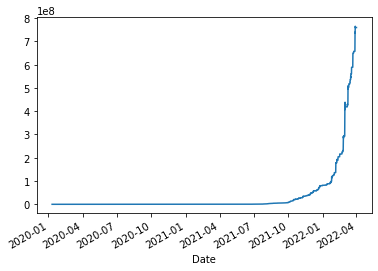

In [20]:
# Calculate and plot the cumulative returns for the `actual_returns` and the `trading_algorithm_returns`

display((1 + predictions_df['trading_algo_returns_3_+1']).plot())

<AxesSubplot:xlabel='Date'>

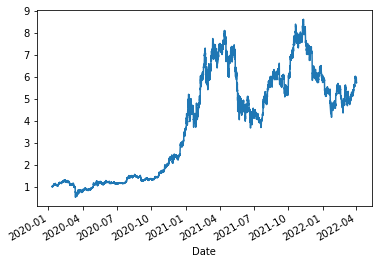

In [21]:
display((1 + predictions_df['actual_return']).cumprod().plot())